In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

# Individual Model Evaluation

In [160]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(scores['precision']), float(scores['f1'])])
    print(table)

In [161]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        auc_scores = {'mean_auc': data[dataset]['auc']}
        auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl", rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--', label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score', title=f'AUC Scores per Class for {dataset}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [162]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}
    
    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [163]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(data['jigsaw'], data['secondary_neutral'])

In [164]:
def confusion_matrix(confusion_dict):
    table = PrettyTable()
    table.field_names = ['', 'Actual Positive', 'Actual Negative']
    
    table.add_row(['Predicted Positive', confusion_dict['tp'], confusion_dict['fp']])
    table.add_row(['Predicted Negative', confusion_dict['fn'], confusion_dict['tn']])
    
    print(table)

In [165]:
# confusion_matrix_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json'
# with open(confusion_matrix_data, 'r') as f:
#     data = json.load(f)

# confusion_data = data['secondary_positive']['confusion_matrix']
# confusion_matrix(confusion_data)

# Model Data Ratio Investigation

In [166]:
# ratio_paths = {
#     "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
#     "100:5:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
#     "100:10:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
#     "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:1-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1_5/checkpoints/converted/epoch=2_test_results.json',
#     "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0-step=8942_test_results.json',
#     "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
#     "100:200:50-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=3_test_results.json',
#     "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json'
# }

# ratio_paths = {
#     "AGB-1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-1/checkpoints/converted/epoch=2_test_results.json',
#     "AGB-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-5/checkpoints/converted/epoch=2_test_results.json',
#     "AGB-10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
# }

ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=1_test_results_j.json',
    "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=1_test_results_j.json',
}

ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_sn.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=1_test_results_sn.json',
    "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=1_test_results_sn.json',
}

In [167]:
def plot_ratio_scores(df, dataset):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(f"{dataset} Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Precision', 'Recall', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Precision'], row['Recall'], row['F1']])
    # print(table)

In [168]:
dataset = 'jigsaw'
dataset = 'secondary_neutral'
# dataset = 'secondary_positive'
dataset_name = " ".join([w[0].upper() + w[1:] for w in dataset.split("_")])
final_df = pd.DataFrame()
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)[dataset]
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1']]
        df['ratio'] = ratio
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'ratio': 'Ratio'
})

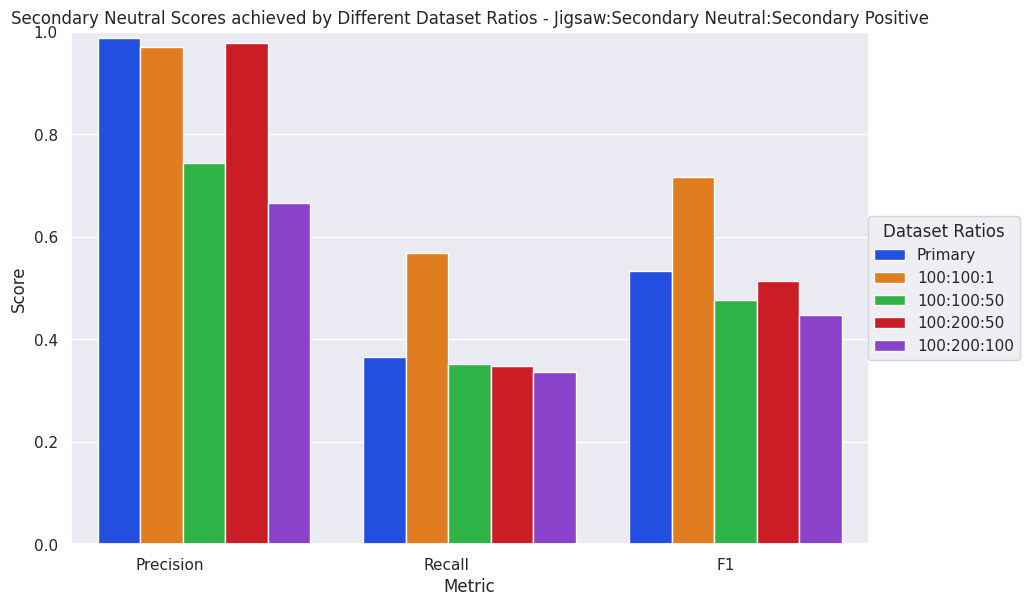

In [169]:
plot_ratio_scores(final_df, dataset=dataset_name)


In [212]:
def create_final_df(result_paths, first_row, beta=1.0, secondary_positive=True):
    datasets = [("jigsaw", "J"), ("secondary_neutral", "SN")]
    columns = [first_row, "Precision (J)", "Recall (J)", "F-β (J)", "Precision (SN)", "Recall (SN)", "F-β (SN)"]
    if secondary_positive:
        datasets += [("secondary_positive", "SP")]
        columns += ["Precision (SP)", "Recall (SP)", "F-β (SP)"]
    final_df = pd.DataFrame(columns=columns)
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for (dataset, acronym) in datasets:
                d = data[dataset]
                if (beta**2 * d['precision']) + d['recall'] == 0:
                    f_beta = 0
                else:
                    f_beta = ((1 + beta**2) * d['precision'] * d['recall']) / ((beta**2 * d['precision']) + d['recall'])
                new_row |= {
                    f"Precision ({acronym})": "{:1.4f}".format(d['precision']),
                    f"Recall ({acronym})": "{:1.4f}".format(d['recall']),
                    f"F-β ({acronym})": "{:1.4f}".format(f_beta)
                }

        final_df = pd.concat(
            [final_df, pd.DataFrame([new_row])], ignore_index=True)

    if secondary_positive:
        final_df['DPS'] = 0.4 * final_df['F-β (J)'].astype(float) + 0.4 * final_df['F-β (SN)'].astype(float) + 0.2 * final_df['F-β (SP)'].astype(float)
        final_df['DPS'] = final_df['DPS'].map('{:1.4f}'.format)
    return final_df



In [213]:
def table_ratio_results(table_data):
    table = PrettyTable()
    table.field_names = ['Ratio', "Precision (J)", "Recall (J)", "F-β (J)", "Precision (SN)",
                         "Recall (SN)", "F-β (SN)", "Precision (SP)", "Recall (SP)", "F-β (SP)", "DPS"]
    for _, row in table_data.iterrows():
        table.add_row([
            row['Ratio'],
            row['Precision (J)'],
            row['Recall (J)'],
            row['F-β (J)'],
            row['Precision (SN)'],
            row['Recall (SN)'],
            row['F-β (SN)'],
            row['Precision (SP)'],
            row['Recall (SP)'],
            row['F-β (SP)'],
            row['DPS']
        ])
    print("Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive")
    print(table)
    print("Key: J = Jigsaw | SN = Secondary Neutral | SP = Secondary Positive")

In [214]:
def highlight_all_extremes(s):
    if s.name in ["Ratio", "Model", "Precision (SP)"]:
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()

        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]


In [215]:
def highlight_extremes(s):
    if s.name in ["Ratio", "Model", "Precision (SP)"]:
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()

        if is_max.iloc[0]:
            is_max.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values(ascending=False)
            if not sorted_values.empty:
                second_max_index = sorted_values.index[0]
                is_max.loc[second_max_index] = True
        if is_min.iloc[0]:
            is_min.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values()
            if not sorted_values.empty:
                second_min_index = sorted_values.index[0]
                is_min.loc[second_min_index] = True

        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]


In [216]:
def highlight_extremes_triples(s):
    if s.name == "Ratio" or s.name == "Model" or s.name == "Precision (SP)":
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()
        is_max[0] = False 
        is_min[0] = False 
        
        for i in range(1, len(s), 3):
            section_max = s.iloc[i:i+3].max()
            section_min = s.iloc[i:i+3].min()
            
            if not pd.isnull(section_max):
                is_max.iloc[i:i+3] |= (s.iloc[i:i+3] == section_max)
                
            if not pd.isnull(section_min):
                is_min.iloc[i:i+3] |= (s.iloc[i:i+3] == section_min)
                
        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]


In [217]:
ratio_paths = {
    "AGB-1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-1/checkpoints/converted/epoch=2_test_results.json',
    "AGB-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-5/checkpoints/converted/epoch=2_test_results.json',
    "AGB-10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
}
ratio_df = create_final_df(ratio_paths, "Ratio", beta=2)
display(ratio_df.style.apply(highlight_all_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,AGB-1,0.9135,0.6386,0.6795,0.9914,0.2846,0.3319,0.0000,0.0000,0.0000,0.4046
1,AGB-5,0.9055,0.6735,0.7099,0.9763,0.3718,0.4243,0.0000,0.0000,0.0000,0.4537
2,AGB-10,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478


In [218]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=1_test_results_j.json',
    "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=1_test_results_j.json',
}

ratio_paths_sn = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_sn.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=1_test_results_sn.json',
    "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=1_test_results_sn.json',
}
ratio_df_j = create_final_df(ratio_paths_j, "Ratio", beta=2)
display(ratio_df_j.style.apply(highlight_extremes))
ratio_df_sn = create_final_df(ratio_paths_sn, "Ratio", beta=2)
display(ratio_df_sn.style.apply(highlight_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9090,0.7022,0.7357,0.9287,0.6929,0.7300,1.0000,0.4127,0.4676,0.6798
2,100:100:50,0.9146,0.6426,0.6832,0.7242,0.5804,0.6044,1.0000,0.9087,0.9256,0.7002
3,100:200:50,0.8981,0.6708,0.7066,0.8553,0.7783,0.7926,1.0000,0.6786,0.7252,0.7447
4,100:200:100,0.9019,0.5558,0.6020,0.6591,0.4413,0.4725,1.0000,0.7897,0.8244,0.5947


,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9608,0.5490,0.6005,0.9709,0.5678,0.6192,1.0000,0.2222,0.2631,0.5405
2,100:100:50,0.9737,0.4639,0.5182,0.7439,0.3516,0.3931,1.0000,0.8373,0.8655,0.5376
3,100:200:50,0.9957,0.2051,0.2438,0.9791,0.3488,0.4003,1.0000,0.4008,0.4554,0.3487
4,100:200:100,0.9428,0.4653,0.5177,0.6662,0.3371,0.3741,1.0000,0.7540,0.7930,0.5153


In [219]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_j.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_j.json',
}

ratio_paths_sn = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_sn.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_sn.json',
}
ratio_df_j = create_final_df(ratio_paths_j, "Ratio", beta=2)
display(ratio_df_j.style.apply(highlight_extremes))
ratio_df_sn = create_final_df(ratio_paths_sn, "Ratio", beta=2)
display(ratio_df_sn.style.apply(highlight_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9086,0.7076,0.7404,0.8937,0.7702,0.7921,1.0000,0.4762,0.5319,0.7194
2,100:200:50,0.9120,0.6588,0.6975,0.8971,0.6566,0.6938,1.0000,0.8095,0.8416,0.7248


,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9781,0.4796,0.5340,0.9773,0.5795,0.6309,1.0000,0.3143,0.3643,0.5388
2,100:200:50,0.9855,0.3350,0.3860,0.9500,0.3737,0.4253,1.0000,0.7238,0.7661,0.4777


In [220]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
}

ratio_paths_sn = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
}
ratio_df_j = create_final_df(ratio_paths_j, "Ratio", beta=2)
display(ratio_df_j.style.apply(highlight_extremes))
ratio_df_sn = create_final_df(ratio_paths_sn, "Ratio", beta=2)
display(ratio_df_sn.style.apply(highlight_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9007,0.7026,0.7349,0.9178,0.7122,0.7456,1.0000,0.3415,0.3933,0.6709


,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9660,0.5217,0.5746,0.9773,0.5419,0.5949,1.0000,0.2439,0.2874,0.5253


In [221]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_j.json',
}

ratio_paths_sn = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_sn.json',
}
ratio_df_j = create_final_df(ratio_paths_j, "Ratio", beta=2)
display(ratio_df_j.style.apply(highlight_extremes))
ratio_df_sn = create_final_df(ratio_paths_sn, "Ratio", beta=2)
display(ratio_df_sn.style.apply(highlight_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9173,0.6950,0.7304,0.9363,0.7060,0.7425,1.0000,0.6400,0.6897,0.7271
2,100:200:50,0.9127,0.6605,0.6991,0.9419,0.6606,0.7026,1.0000,0.6000,0.6522,0.6911


,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,100:100:1,0.9651,0.5455,0.5975,0.9755,0.5859,0.6368,1.0000,0.4800,0.5357,0.6009
2,100:200:50,0.9553,0.5163,0.5686,0.9736,0.5024,0.5562,1.0000,0.6000,0.6522,0.5804


# Primary vs Secondary Model Investigation

In [222]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "Topic 4": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_j.json',
    "Topic 6": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "Topic 7": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "Topic 10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
}

topic_paths_sn = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results.json',
    "Topic 4": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_sn.json',
    "Topic 6": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
    "Topic 7": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
    "Topic 10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_sn.json',
}

topic_df_j = create_final_df(topic_paths_j, "Model", beta=2)
display(topic_df_j.style.apply(highlight_extremes))
topic_df_sn = create_final_df(topic_paths_sn, "Model", beta=2)
display(topic_df_sn.style.apply(highlight_extremes))

,Model,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,Topic 4,0.9086,0.7076,0.7404,0.8937,0.7702,0.7921,1.0000,0.4762,0.5319,0.7194
2,Topic 6,0.9090,0.7022,0.7357,0.9287,0.6929,0.7300,1.0000,0.4127,0.4676,0.6798
3,Topic 7,0.9007,0.7026,0.7349,0.9178,0.7122,0.7456,1.0000,0.3415,0.3933,0.6709
4,Topic 10,0.9173,0.6950,0.7304,0.9363,0.7060,0.7425,1.0000,0.6400,0.6897,0.7271


,Model,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Precision (SP),Recall (SP),F-β (SP),DPS
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,0.0000,0.0000,0.0000,0.4478
1,Topic 4,0.9781,0.4796,0.5340,0.9773,0.5795,0.6309,1.0000,0.3143,0.3643,0.5388
2,Topic 6,0.9608,0.5490,0.6005,0.9709,0.5678,0.6192,1.0000,0.2222,0.2631,0.5405
3,Topic 7,0.9660,0.5217,0.5746,0.9773,0.5419,0.5949,1.0000,0.2439,0.2874,0.5253
4,Topic 10,0.9651,0.5455,0.5975,0.9755,0.5859,0.6368,1.0000,0.4800,0.5357,0.6009


In [238]:
def compare_primary_secondary(df, first_column="Model", grouping_count=3):
    df_melt = df.melt(id_vars=[first_column], var_name='score', value_name='value')
    df_melt['value'] = pd.to_numeric(df_melt['value'])

    sns.set(style="darkgrid")
    colors = sns.color_palette("husl", n_colors=len(df_melt[first_column].unique()))

    g = sns.catplot(x='score', y='value', hue=first_column, data=df_melt, kind='bar', palette=colors,
                    sharey=False, aspect=2, height=6, errorbar=None, dodge=True)

    # Add vertical dotted line every dataset
    for i in range(grouping_count, len(df_melt['score'].unique()), grouping_count):
        plt.axvline(x=i-0.5, linestyle='--', color='gray')

    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()
    # Calculate the average scores within each group
    avg_scores = df_melt[df_melt[first_column] != 'Primary'].groupby('score', sort=False)['value'].mean()[::-1]
    x_positions = np.arange(len(avg_scores))

    group_width = len(df_melt[first_column].unique())

    # Plot the average line within each group
    for x, avg_score in zip(x_positions, reversed(avg_scores)):
        start = x - (group_width - 1) / (len(df)*2)
        end = x + (group_width - 1) / (len(df)*2)
        plt.plot([start, end], [avg_score, avg_score], linestyle='--', color='black', alpha=0.5)
        plt.text(x - (group_width - 1) / 20, avg_score + 0.01, f"{avg_score:.4f}", fontsize=9)

    plt.legend(title='Models', loc='center right', bbox_to_anchor=(1.12, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Models")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


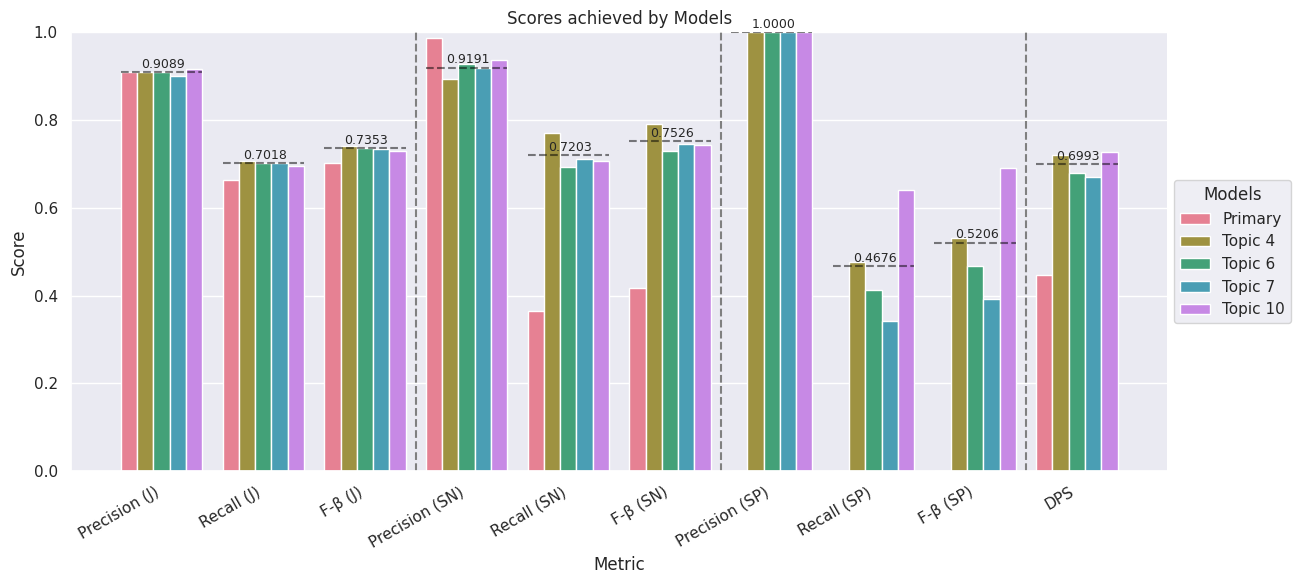

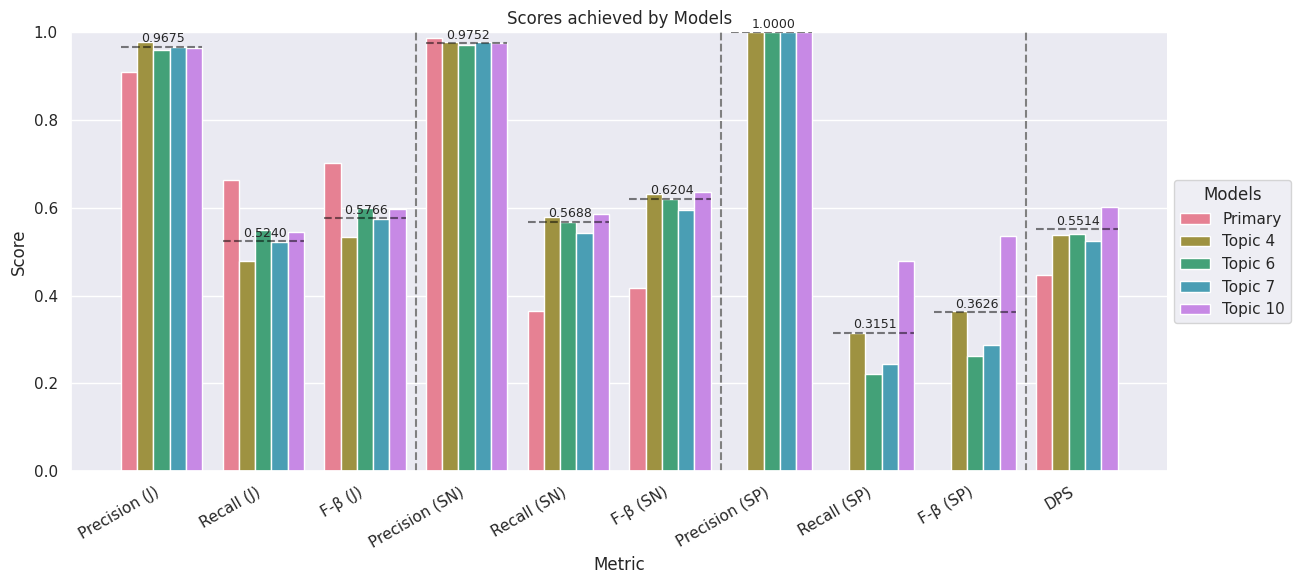

In [239]:
compare_primary_secondary(topic_df_j)
compare_primary_secondary(topic_df_sn)

# Combined Secondary Evaluation

In [253]:
def create_secondary_df(result_paths, first_row, beta=1.0):
    final_df = pd.DataFrame(columns=[first_row, 
                                     "Topic 4 (R)", "Topic 4 (F-β)",
                                     "Topic 6 (R)", "Topic 6 (F-β)",
                                     "Topic 7 (R)", "Topic 7 (F-β)",
                                     "Topic 10 (R)", "Topic 10 (F-β)",
                                     "Mean (R)", "Mean (F-β)"])
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for topic in ["Topic 4", "Topic 6", "Topic 7", "Topic 10", "Mean"]:
                topic_str = "_".join(topic.lower().split(" "))
                d = data["secondary_positive"][topic_str]
                if (beta**2 * d['precision']) + d['recall'] == 0:
                    f_beta = 0
                else:
                    f_beta = ((1 + beta**2) * d['precision'] * d['recall']) / ((beta**2 * d['precision']) + d['recall'])
                new_row |= {
                    f"{topic} (R)": "{:1.4f}".format(d['recall']),
                    f"{topic} (F-β)": "{:1.4f}".format(f_beta)
                }
            

        if float(new_row["Mean (R)"]) > 0:
            final_df = pd.concat(
                [final_df, pd.DataFrame([new_row])], ignore_index=True)

    return final_df



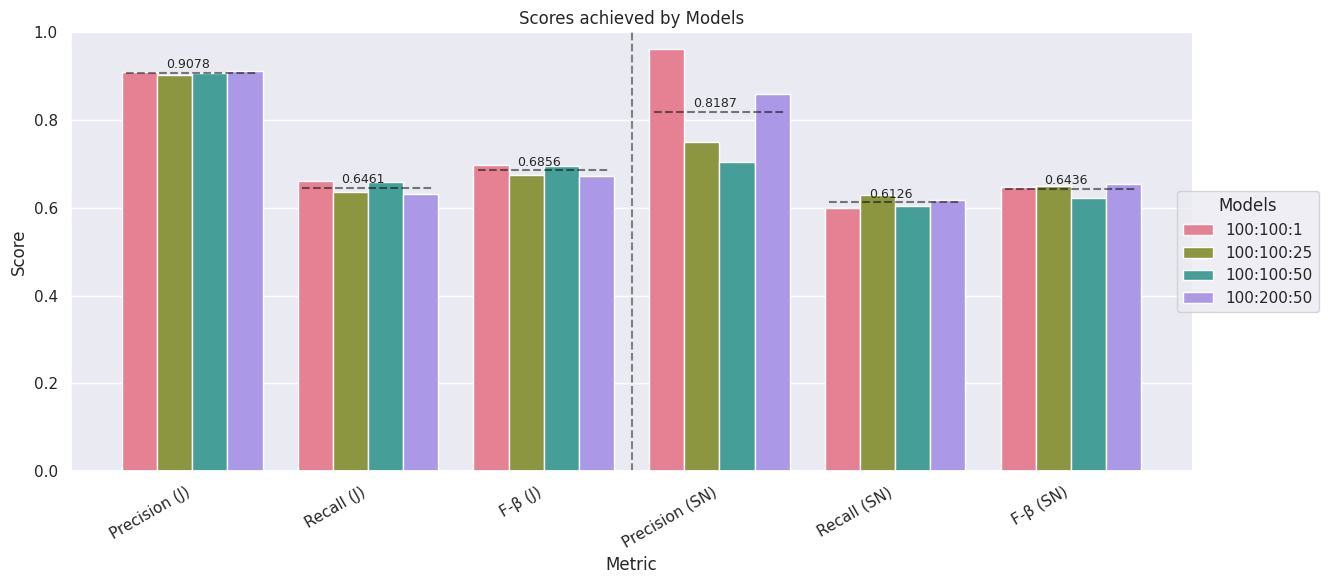

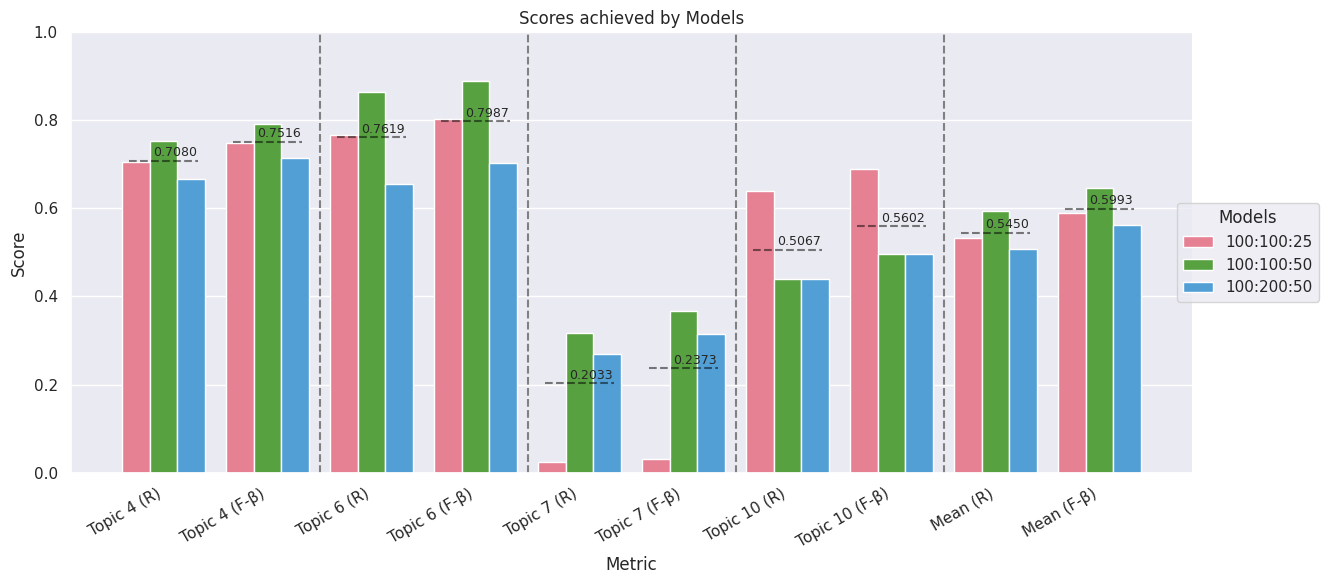

In [256]:
secondary_ratio_paths_j = {
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:25": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-25/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_j.json'
}

secondary_ratio_paths_sn = {
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results_sn.json',
    "100:100:25": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-25/checkpoints/converted/epoch=0_test_results_sn.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_sn.json',
    "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results_sn.json'
}

final_ratio_df_j = create_final_df(secondary_ratio_paths_j, "Ratio", beta=2, secondary_positive=False)
secondary_ratio_df_j = create_secondary_df(secondary_ratio_paths_j, "Ratio", beta=2)
compare_primary_secondary(final_ratio_df_j, first_column="Ratio")
compare_primary_secondary(secondary_ratio_df_j, first_column="Ratio", grouping_count=2)
# final_ratio_df_sn = create_final_df(secondary_ratio_paths_sn, "Ratio", beta=2, secondary_positive=False)
# secondary_ratio_df_sn = create_secondary_df(secondary_ratio_paths_sn, "Ratio", beta=2)
# compare_primary_secondary(final_ratio_df_sn, first_column="Ratio")
# compare_primary_secondary(secondary_ratio_df_sn, first_column="Ratio", grouping_count=2)